<a href="https://colab.research.google.com/github/senakilinc/ReachToGraspPrediction/blob/main/Prediction_ReachToGraspData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Masking


In [2]:
#dataset path
REACH_DIR = "/content/drive/MyDrive/reach"

In [3]:
with open(os.path.join(REACH_DIR, "header.txt")) as f:
    header = f.read().strip().split(",")

In [4]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def extract_sequence_with_cutoff(filepath, cutoff_ms, use_palm=True, n_fingers=3):
    df = pd.read_csv(filepath, names=header)

    if len(df) < 2 or df["FrameTime"].iloc[-1] < cutoff_ms:
        return None, None

    cutoff_time = df["FrameTime"].iloc[-1] - cutoff_ms
    input_df = df[df["FrameTime"] <= cutoff_time]

    if len(input_df) < 2:
        return None, None

    sequence = []
    for _, row in input_df.iterrows():
        cx, cy, cz = row["M12x"], row["M12y"], row["M12z"]
        frame_features = []
        for i in range(1, n_fingers + 1):
            x = row[f"M{i}x"] - cx
            y = row[f"M{i}y"] - cy
            z = row[f"M{i}z"] - cz
            frame_features.extend([x, y, z])
        if use_palm:
            frame_features.extend([cx, cy, cz])
        sequence.append(frame_features)

    # Target = final pose
    last = df.iloc[-1]
    cx, cy, cz = last["M12x"], last["M12y"], last["M12z"]
    target = []
    for i in range(1, n_fingers + 1):
        x = last[f"M{i}x"] - cx
        y = last[f"M{i}y"] - cy
        z = last[f"M{i}z"] - cz
        target.extend([x, y, z])
    if use_palm:
        target.extend([cx, cy, cz])
    return sequence, target

In [6]:
def get_frame_times(filepath, cutoff_ms):
    """
    Returns FrameTime values (in ms) for a given trial, up to cutoff_ms.
    Useful for timing each frame in an animation.
    """
    df = pd.read_csv(filepath, names=header)

    if len(df) < 2 or df["FrameTime"].iloc[-1] < cutoff_ms:
        return None

    cutoff_time = df["FrameTime"].iloc[-1] - cutoff_ms
    input_df = df[df["FrameTime"] <= cutoff_time]

    if len(input_df) < 2:
        return None

    return input_df["FrameTime"].tolist()


In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def prepare_data(REACH_DIR, cutoff_ms, use_palm=True, n_fingers=3):
    X, y, meta = [], [], []

    for fname in os.listdir(REACH_DIR):
        if not fname.endswith(".txt") or fname == "header.txt":
            continue
        seq, target = extract_sequence_with_cutoff(
            os.path.join(REACH_DIR, fname), cutoff_ms, use_palm, n_fingers)
        if seq is not None:
            X.append(np.array(seq, dtype='float32'))
            y.append(target)
            meta.append(fname)

    if len(X) < 10:
        raise ValueError("Too few valid sequences.")

    y = np.array(y, dtype='float32')
    X_flat = np.concatenate(X)
    X_scaler = StandardScaler().fit(X_flat)
    y_scaler = StandardScaler().fit(y)

    X_scaled = [X_scaler.transform(seq) for seq in X]
    y_scaled = y_scaler.transform(y)

    X_padded = pad_sequences(X_scaled, padding='pre', dtype='float32')

    return X_padded, y_scaled, X_scaler, y_scaler, meta, X_scaled

In [8]:
def build_model(input_shape, output_dim, use_masking=True):
    model = Sequential()
    if use_masking:
        model.add(Masking(mask_value=0.0, input_shape=input_shape))
    else:
        model.add(tf.keras.layers.Input(shape=input_shape))

    model.add(LSTM(64, recurrent_activation='sigmoid', recurrent_dropout=0, unroll=False, use_bias=True)) #disable cuDNN by setting use_bias=True or recurrent_activation or recurrent_dropout or unroll
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_dim))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [9]:
import tensorflow as tf

def run_experiment(REACH_DIR, cutoff_ms, use_palm, n_fingers, use_masking, epochs, batch_size, seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    X, y, X_scaler, y_scaler, meta, X_scaled = prepare_data(REACH_DIR, cutoff_ms, use_palm, n_fingers)

    X_train, X_test, y_train, y_test, meta_train, meta_test, X_scaled_train, X_scaled_test = train_test_split(
        X, y, meta, X_scaled, test_size=0.2, random_state=seed)

    model = build_model(X_train.shape[1:], y.shape[1], use_masking)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    # Evaluate on test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    y_test_rescaled = y_scaler.inverse_transform(y_test)
    mae = np.mean(np.abs(y_pred_rescaled - y_test_rescaled))

    print(f"Cutoff {cutoff_ms} ms — MAE: {mae:.4f} cm")

    # Return everything needed for post-analysis
    return model, history, mae, X_test, y_test, y_test_rescaled, y_scaler, meta_test, X_scaled_train, X_scaled_test

In [35]:
def plot_training_history(history):
    # Create a new figure and a 2D axes object explicitly
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'], label='Train Loss')
    ax.plot(history.history['val_loss'], label='Val Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training vs Validation Loss')
    ax.legend()
    ax.grid(True)
    plt.show()

### Cutoff loop

In [43]:
cutoff_values = list(range(0, 400, 50))  # Try cutoffs from 0ms to 350ms
mae_results_no_palm = []

for cutoff in cutoff_values:
    print(f"Running cutoff = {cutoff} ms")
    try:
        _, _, mae, _,_,_,_,_,_,_ = run_experiment(
            REACH_DIR,
            cutoff_ms=cutoff,
            use_palm=False,
            n_fingers=3,
            use_masking=False,
            epochs=20,
            batch_size=16,
            seed=42
        )
        mae_results_no_palm.append((cutoff, mae))
    except ValueError as e:
        print(f"Skipped cutoff {cutoff}: {e}")


Running cutoff = 0 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 0 ms — MAE: 0.1802 cm
Running cutoff = 50 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Cutoff 50 ms — MAE: 0.3210 cm
Running cutoff = 100 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Cutoff 100 ms — MAE: 0.4284 cm
Running cutoff = 150 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cutoff 150 ms — MAE: 0.5193 cm
Running cutoff = 200 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Cutoff 200 ms — MAE: 0.6275 cm
Running cutoff = 250 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Cutoff 250 ms — MAE: 0.7215 cm
Running cutoff = 300 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Cutoff 300 ms — MAE: 0.7676 cm
Running cutoff = 350 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 350 ms — MAE: 0.8423 cm


In [44]:
cutoff_values = list(range(0, 400, 50))  # Try cutoffs from 0ms to 350ms
mae_results_yes_palm = []

for cutoff in cutoff_values:
    print(f"Running cutoff = {cutoff} ms")
    try:
        _, _, mae, _,_,_,_,_,_,_ = run_experiment(
            REACH_DIR,
            cutoff_ms=cutoff,
            use_palm=True,
            n_fingers=3,
            use_masking=False,
            epochs=20,
            batch_size=16,
            seed=42
        )
        mae_results_yes_palm.append((cutoff, mae))
    except ValueError as e:
        print(f"Skipped cutoff {cutoff}: {e}")

Running cutoff = 0 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Cutoff 0 ms — MAE: 0.2594 cm
Running cutoff = 50 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Cutoff 50 ms — MAE: 0.3602 cm
Running cutoff = 100 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Cutoff 100 ms — MAE: 0.4543 cm
Running cutoff = 150 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Cutoff 150 ms — MAE: 0.5066 cm
Running cutoff = 200 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Cutoff 200 ms — MAE: 0.5963 cm
Running cutoff = 250 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Cutoff 250 ms — MAE: 0.6731 cm
Running cutoff = 300 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Cutoff 300 ms — MAE: 0.7540 cm
Running cutoff = 350 ms
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Cutoff 350 ms — MAE: 0.8076 cm


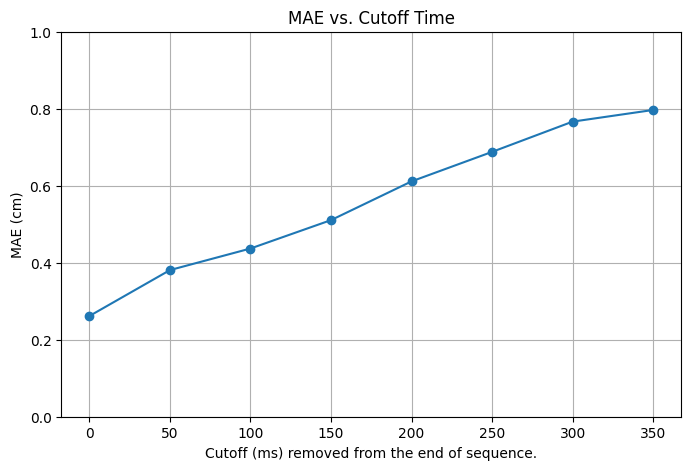

In [29]:
# Unpack results
cutoffs, maes = zip(*mae_results)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(cutoffs, maes, marker='o')
plt.title('MAE vs. Cutoff Time')
plt.xlabel('Cutoff (ms) removed from the end of sequence.')
plt.ylabel('MAE (cm)')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


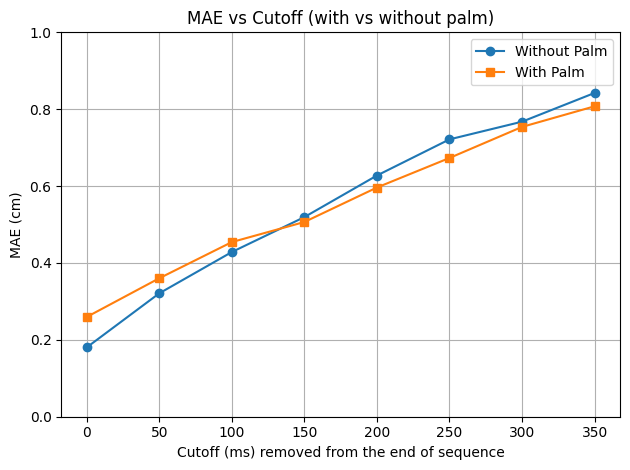

In [45]:
cutoffs_no_palm, maes_no_palm = zip(*mae_results_no_palm)
cutoffs_yes_palm, maes_yes_palm = zip(*mae_results_yes_palm)

# Plot both lines
plt.plot(cutoffs_no_palm, maes_no_palm, marker='o', label="Without Palm")
plt.plot(cutoffs_yes_palm, maes_yes_palm, marker='s', label="With Palm")

# Labels and styling
plt.title("MAE vs Cutoff (with vs without palm)")
plt.xlabel("Cutoff (ms) removed from the end of sequence")
plt.ylabel("MAE (cm)")
plt.ylim(0, 1)  # Force Y-axis to stay between 0 and 1 cm
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Experimenting with 0ms cutoff:

In [45]:
model, history, mae, X_test, y_test, y_test_rescaled, y_scaler, meta_test, X_scaled_train, X_scaled_test= run_experiment(
    REACH_DIR, cutoff_ms=0, use_palm=True, n_fingers=3, use_masking=False, epochs=20, batch_size=16, seed=42)

plot_training_history(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Cutoff 0 ms — MAE: 0.2756 cm


<IPython.core.display.Javascript object>

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_downsampled_predictions(model, sequence, total_timesteps, frame_times, max_frames=30):
    """
    Generates predictions for a sequence at downsampled time points.

    Args:
        model: The trained Keras model.
        sequence: The input sequence (already scaled and padded).
        total_timesteps: Total number of timesteps in the padded sequence.
        frame_times: List of actual frame times (in ms) for the original sequence.
        max_frames: The desired number of frames for downsampling.

    Returns:
        predictions: A list of predictions at the downsampled time points.
        times: A list of corresponding frame times (in ms).
    """
    # Pick 7 evenly spaced time steps from the original sequence length
    # instead of padded sequence length to align indices with frame_times
    indices = np.linspace(1, len(frame_times) - 1, max_frames)
    indices = np.round(indices).astype(int)
    indices = np.unique(np.clip(indices, 1, len(frame_times) - 1))


    predictions = []
    times = []
    print("indices:" , indices)
    for t in indices:
        partial = sequence[:t]
        padded = pad_sequences([partial.tolist()], maxlen=total_timesteps, padding='pre', dtype='float32')
        pred_scaled = model.predict(padded, verbose=0)[0]
        #print("for frame", t, ":", "partial:", partial, " padded:", padded)
        if t==256:
          print(type(partial))
          print(partial)
          print(padded)
          print("partial length:", len(partial))
          print("padded length:", len(padded))
          print("last arrays of padded:", padded[0][-5:])
          print(pred_scaled)
          predtest = y_scaler.inverse_transform([pred_scaled])[0]
          print(predtest)
          step2= padded
        if t==384:
          print(type(partial))
          print(partial)
          print(padded.shape)
          print("partial length:", len(partial))
          print("padded length:", len(padded))
          print("last arrays of padded:", padded[0][-5:])
          print(pred_scaled)
          predtest = y_scaler.inverse_transform([pred_scaled])[0]
          print(predtest)
          step3 = padded
          result_variable = (step2 == step3).all()

          if(result_variable == True):
            print("unfortunately we have a match")

        predictions.append(pred_scaled)
        times.append(frame_times[t - 1])  # Actual ms of input seen

    return predictions, times

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import numpy as np
import os

def save_hand_prediction_gif_matplotlib(predictions, ground_truth, scaler, times, filename="hand_prediction.gif"):
    folder = "frames_temp"
    os.makedirs(folder, exist_ok=True)

    #finger_labels = ["Thumb", "Index", "Middle"]
    finger_labels = ["T", "I", "M"]
    gt_palm = ground_truth[9:12]
    gt_fingers = np.array(ground_truth[:9]).reshape(3, 3) + gt_palm

    # Calculate axis limits based on ground truth and all predictions
    all_gt_fingers = [np.array(scaler.inverse_transform([p])[0][:9].reshape(3, 3) + scaler.inverse_transform([p])[0][9:12]) for p in predictions]
    all_gt_fingers = np.vstack(all_gt_fingers)
    all_gt_palms = [scaler.inverse_transform([p])[0][9:12] for p in predictions]
    all_gt_palms = np.vstack(all_gt_palms)
    all_pred_fingers = [np.array(ground_truth[:9]).reshape(3, 3) + ground_truth[9:12]]
    all_pred_fingers = np.vstack(all_pred_fingers)
    all_pred_palms = [ground_truth[9:12]]
    all_pred_palms = np.vstack(all_pred_palms)
    all_points = np.vstack([all_gt_fingers, all_gt_palms, all_pred_fingers, all_pred_palms])

    xlim = (np.min(all_points[:, 0]) - 2, np.max(all_points[:, 0]) + 2)
    ylim = (np.min(all_points[:, 1]) - 2, np.max(all_points[:, 1]) + 2)
    zlim = (np.min(all_points[:, 2]) - 2, np.max(all_points[:, 2]) + 2)

    frame_paths = []

    # Create the initial plot with ground truth hand
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=20, azim=-70)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    # Ground truth lines (plotted only once)
    for j in range(3):
        ax.plot(
            [gt_palm[0], gt_fingers[j, 0]],
            [gt_palm[1], gt_fingers[j, 1]],
            [gt_palm[2], gt_fingers[j, 2]],
            'g-'
        )
        ax.text(gt_fingers[j, 0], gt_fingers[j, 1], gt_fingers[j, 2], finger_labels[j], color='green')

    ax.scatter(gt_palm[0], gt_palm[1], gt_palm[2], c='green')
    ax.text(gt_palm[0], gt_palm[1], gt_palm[2], 'Palm', color='green')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Now loop through predictions and only update the prediction lines
    for i, pred_scaled in enumerate(predictions):
        pred = scaler.inverse_transform([pred_scaled])[0]
        pred_palm = pred[9:12]
        pred_fingers = np.array(pred[:9]).reshape(3, 3) + pred_palm

        # Remove previous prediction lines if they exist
        if i > 0:
            for line in pred_lines:
                line.remove()
            for text in pred_texts:
                text.remove()

        # Prediction lines (updated for each frame)
        pred_lines = []
        pred_texts = []
        for j in range(3):
            line, = ax.plot(
                [pred_palm[0], pred_fingers[j, 0]],
                [pred_palm[1], pred_fingers[j, 1]],
                [pred_palm[2], pred_fingers[j, 2]],
                'r--'
            )
            pred_lines.append(line)

            text = ax.text(pred_fingers[j, 0], pred_fingers[j, 1], pred_fingers[j, 2], finger_labels[j], color='red') # Using initials
            pred_texts.append(text)

        ax.scatter(pred_palm[0], pred_palm[1], pred_palm[2], c='red') # Palm marker, no text
        # Removed: ax.text(pred_palm[0], pred_palm[1], pred_palm[2], 'Palm', color='red')
        ax.set_title(f"Step {i+1} | Input time: {times[i]:.1f} ms")
        frame_path = os.path.join(folder, f"frame_{i:03d}.png")
        plt.tight_layout()
        plt.savefig(frame_path)
        frame_paths.append(frame_path)

    # Assemble into GIF
    images = [imageio.v2.imread(fp) for fp in frame_paths]
    imageio.mimsave(filename, images, duration=500.0)
    print(f" GIF saved to: {filename} ({len(images)} frames)")

    # Clean up
    for fp in frame_paths:
        os.remove(fp)
    os.rmdir(folder)
    plt.show()
    print('why it no work')

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import numpy as np
import os

def save_hand_prediction_gif_matplotlib(predictions, ground_truth, scaler, times, original_sequence, filename="hand_prediction.gif"):
    folder = "frames_temp"
    os.makedirs(folder, exist_ok=True)

    finger_labels = ["T", "I", "M"]  # Shortened finger labels
    gt_palm = ground_truth[9:12]
    gt_fingers = np.array(ground_truth[:9]).reshape(3, 3) + gt_palm

    # *** Calculate axis limits before the loop ***
    # Include ground truth, all predictions, and all actual hand positions
    all_points = []

    # Add ground truth hand points
    all_points.extend(gt_fingers.flatten())
    all_points.extend(gt_palm)

    # Add predicted hand points for all frames
    for pred_scaled in predictions:
        pred = scaler.inverse_transform([pred_scaled])[0]
        pred_palm = pred[9:12]
        pred_fingers = np.array(pred[:9]).reshape(3, 3) + pred_palm
        all_points.extend(pred_fingers.flatten())
        all_points.extend(pred_palm)

    # Add actual hand points for all frames
    for i in range(len(times)):
        current_time_index = times[i]
        closest_time_index = np.abs(np.array(original_sequence['FrameTime']) - current_time_index).argmin()
        actual_hand_data = original_sequence.iloc[closest_time_index]
        actual_palm = [actual_hand_data['M12x'], actual_hand_data['M12y'], actual_hand_data['M12z']]
        actual_fingers = [
            [actual_hand_data[f'M{j}x'] - actual_palm[0],
             actual_hand_data[f'M{j}y'] - actual_palm[1],
             actual_hand_data[f'M{j}z'] - actual_palm[2]] for j in range(1, 4)
        ]
        actual_fingers = np.array(actual_fingers)
        all_points.extend(actual_fingers.flatten())
        all_points.extend(actual_palm)

    all_points = np.array(all_points).reshape(-1, 3)  # Reshape to (N, 3)

    xlim = (np.min(all_points[:, 0]) - 2, np.max(all_points[:, 0]) + 2)
    ylim = (np.min(all_points[:, 1]) - 2, np.max(all_points[:, 1]) + 2)
    zlim = (np.min(all_points[:, 2]) - 2, np.max(all_points[:, 2]) + 2)
    # *** End of axis limit calculation ***

    frame_paths = []

    # Create the initial plot with ground truth hand
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=20, azim=-70)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    # Ground truth lines (plotted only once)
    for j in range(3):
        ax.plot(
            [gt_palm[0], gt_fingers[j, 0]],
            [gt_palm[1], gt_fingers[j, 1]],
            [gt_palm[2], gt_fingers[j, 2]],
            'g-'
        )
        ax.text(gt_fingers[j, 0], gt_fingers[j, 1], gt_fingers[j, 2], finger_labels[j], color='green')

    ax.scatter(gt_palm[0], gt_palm[1], gt_palm[2], c='green')
    ax.text(gt_palm[0], gt_palm[1], gt_palm[2], 'Palm', color='green')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Now loop through predictions and only update the prediction lines
    for i, pred_scaled in enumerate(predictions):
        pred = scaler.inverse_transform([pred_scaled])[0]
        pred_palm = pred[9:12]
        pred_fingers = np.array(pred[:9]).reshape(3, 3) + pred_palm

        # Remove previous prediction lines if they exist
        if i > 0:
            for line in pred_lines:
                line.remove()
            for text in pred_texts:
                text.remove()
            for line in actual_lines:  # Remove actual hand lines
                line.remove()
            for text in actual_texts:  # Remove actual hand text
                text.remove()

        # Prediction lines (updated for each frame)
        pred_lines = []
        pred_texts = []
        for j in range(3):
            line, = ax.plot(
                [pred_palm[0], pred_fingers[j, 0]],
                [pred_palm[1], pred_fingers[j, 1]],
                [pred_palm[2], pred_fingers[j, 2]],
                'r--'
            )
            pred_lines.append(line)

            text = ax.text(pred_fingers[j, 0], pred_fingers[j, 1], pred_fingers[j, 2], finger_labels[j], color='red')
            pred_texts.append(text)

        ax.scatter(pred_palm[0], pred_palm[1], pred_palm[2], c='red')
        ax.set_title(f"Step {i+1} | Input time: {times[i]:.1f} ms")

        # Get actual hand position at current time
        current_time_index = times[i]
        closest_time_index = np.abs(np.array(original_sequence['FrameTime']) - current_time_index).argmin()
        actual_hand_data = original_sequence.iloc[closest_time_index]

        # Reshape and get actual palm and finger coordinates
        actual_palm = [actual_hand_data['M12x'], actual_hand_data['M12y'], actual_hand_data['M12z']]
        actual_fingers = [
            [actual_hand_data[f'M{j}x'] - actual_palm[0],
             actual_hand_data[f'M{j}y'] - actual_palm[1],
             actual_hand_data[f'M{j}z'] - actual_palm[2]] for j in range(1, 4)
        ]
        actual_fingers = np.array(actual_fingers)

        # Plot actual hand position (in blue)
        actual_lines = []  # Store actual hand lines
        actual_texts = []  # Store actual hand text
        for j in range(3):
            line, = ax.plot(
                [actual_palm[0], actual_fingers[j, 0] + actual_palm[0]],
                [actual_palm[1], actual_fingers[j, 1] + actual_palm[1]],
                [actual_palm[2], actual_fingers[j, 2] + actual_palm[2]],
                'b:'  # Blue dotted line
            )
            actual_lines.append(line)

        ax.scatter(actual_palm[0], actual_palm[1], actual_palm[2], c='blue')
        text = ax.text(actual_palm[0], actual_palm[1], actual_palm[2], 'Actual', color='blue')
        actual_texts.append(text)

        frame_path = os.path.join(folder, f"frame_{i:03d}.png")
        plt.tight_layout()
        plt.savefig(frame_path)
        frame_paths.append(frame_path)

    # Assemble into GIF
    images = [imageio.v2.imread(fp) for fp in frame_paths]
    imageio.mimsave(filename, images, duration=500.0)
    print(f" GIF saved to: {filename} ({len(images)} frames)")

    # Clean up
    for fp in frame_paths:
        os.remove(fp)
    os.rmdir(folder)
    plt.show()

In [48]:
i = 0  # Test sequence index
print(meta_test[i])
sequence = X_scaled_test[i] # non padded
print("last 5 unpadded frames:\n", sequence[-5:])
timesteps = X_scaled_test[i].shape[0]
ground_truth = y_test_rescaled[i]
frame_times = get_frame_times(os.path.join(REACH_DIR, meta_test[i]), cutoff_ms=0)
print(timesteps)

user16_R2G_object_Box_Medium_trial3.txt
last 5 unpadded frames:
 [[ 1.4722383  -0.87303257 -0.9848016  -0.18381715 -0.24391922 -0.38190228
   0.3740406  -0.45373306 -0.9352513  -1.335513    1.1760831  -0.59385574]
 [ 1.4808176  -0.87096    -0.9882072  -0.18510006 -0.24388638 -0.3991961
   0.37504813 -0.459258   -0.94818336 -1.3365759   1.1762335  -0.5959648 ]
 [ 1.4876817  -0.8735238  -0.98834103 -0.18610603 -0.25336033 -0.40412936
   0.37526554 -0.46853322 -0.96052456 -1.337532    1.177011   -0.60090107]
 [ 1.4985416  -0.86944574 -0.9906155  -0.18835124 -0.25875187 -0.4142431
   0.37522897 -0.47670445 -0.9745143  -1.3384968   1.1775265  -0.6042813 ]
 [ 1.5082766  -0.86576736 -0.9950318  -0.18619516 -0.2581863  -0.42758632
   0.37408364 -0.48740578 -0.9843034  -1.3393921   1.1781552  -0.6078574 ]]
767


In [55]:
original_sequence = pd.read_csv(os.path.join(REACH_DIR, meta_test[i]), names=header)

In [40]:
print(len(X_scaled_test[i]))

767


In [49]:
file_path = os.path.join(REACH_DIR, meta_test[i])
print(meta_test[i])
frame_times = get_frame_times(file_path, cutoff_ms=0)
print(frame_times)
print(len(frame_times))

user16_R2G_object_Box_Medium_trial3.txt
[0.0, 1.0639, 2.1081, 3.1694, 4.1466, 5.1741, 6.1851, 7.2631, 8.3103, 9.3937, 10.4019, 11.4397, 12.6134, 13.504, 14.4993, 15.6106, 16.703, 17.8251, 18.8044, 19.8163, 20.8667, 21.9387, 22.9637, 24.0253, 25.0655, 26.0563, 27.1606, 28.1064, 29.2136, 30.1551, 31.2443, 32.3037, 33.2764, 34.3854, 35.3918, 36.4097, 37.4119, 38.5473, 39.6103, 40.548, 41.7356, 42.7123, 43.782, 44.7834, 45.9089, 46.891, 47.9069, 48.9183, 50.03, 51.1037, 52.1515, 53.1505, 54.1848, 55.1542, 56.2124, 57.2558, 58.2797, 59.403, 60.4216, 61.4232, 62.4454, 63.5405, 64.5361, 65.5869, 66.7431, 67.7086, 68.7664, 69.8189, 70.9023, 71.8623, 72.897, 74.0197, 75.0889, 76.0266, 77.1696, 78.177, 79.1126, 80.1887, 81.2499, 82.2504, 83.2778, 84.3424, 85.4048, 86.4293, 87.4381, 88.5621, 89.5911, 90.5819, 91.6241, 92.7487, 93.7037, 94.7773, 95.8776, 96.9131, 98.0112, 99.0299, 100.0173, 101.0734, 102.1073, 103.1429, 104.165, 105.178, 106.2058, 107.2703, 108.283, 109.3349, 110.4906, 111.471, 11

In [50]:
predictions, times = get_downsampled_predictions(model, sequence, timesteps, frame_times, max_frames=7)

indices: [  1 128 256 384 511 638 766]
<class 'numpy.ndarray'>
[[ 2.444089    1.6252352  -0.04150455 ...  1.6171528  -1.6631346
  -2.1009977 ]
 [ 2.4392805   1.6247333  -0.04134245 ...  1.6149623  -1.6622299
  -2.0932696 ]
 [ 2.4354622   1.6249158  -0.04094092 ...  1.6125991  -1.6614983
  -2.0857503 ]
 ...
 [ 0.65479666 -0.1275127   0.04314572 ...  0.31824294 -0.58360815
  -0.01500912]
 [ 0.65328044 -0.135523    0.04182113 ...  0.31219003 -0.5778227
  -0.01453475]
 [ 0.6513651  -0.14343397  0.04076942 ...  0.30624712 -0.57201993
  -0.01409704]]
[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.65479666 -0.1275127   0.04314572 ...  0.31824294 -0.58360815
   -0.01500912]
  [ 0.65328044 -0.135523    0.04182113 ...  0.31219003 -0.5778227
   -0.01453475]
  [ 0.6513651  -0.14343397  0.04076942 ...  0.3062471

In [51]:
print(predictions)

[array([ 0.20954913,  0.13436018,  0.06701688,  0.3662672 ,  0.38247684,
       -0.11411991,  0.38749403,  0.19730407,  0.00386103, -0.2068073 ,
       -0.27995476, -0.17934485], dtype=float32), array([ 0.8105627 ,  0.33195028, -0.2839036 ,  0.35474458,  0.03262853,
       -0.4018407 ,  0.5134516 ,  0.13943613, -0.08492975, -0.24368311,
       -0.00238862, -0.4264204 ], dtype=float32), array([ 0.15921387, -0.18053113,  0.11902365, -0.30186456, -0.16674095,
        0.38341248, -0.15738896, -0.09171785,  0.54927456, -0.11278524,
       -0.30911943,  0.19184893], dtype=float32), array([ 0.04061839, -0.6221083 ,  0.24618888, -0.6361081 , -0.2926756 ,
        0.7359403 , -0.48345977, -0.1709847 ,  0.82190055, -0.08968513,
       -0.08426812,  0.42412156], dtype=float32), array([ 0.23517856, -0.42414322,  0.08316821, -0.53361946, -0.32927173,
        0.64530265, -0.23598279, -0.07630224,  0.62894434, -0.40958887,
       -0.08046705,  0.5256567 ], dtype=float32), array([ 0.35394838, -0.264132

In [ ]:
!pip install -U kaleido

In [61]:
%matplotlib notebook
save_hand_prediction_gif_matplotlib(predictions, ground_truth, y_scaler, times, filename="prediction_evolution_updated.gif", original_sequence=original_sequence)

<IPython.core.display.Javascript object>

 GIF saved to: prediction_evolution_updated.gif (7 frames)
